# Bachelorarbeit: Klassifizierung von Hirntumoren mit Algorithmen des Deep Learning

Dieses Jupyter Notebook beschreibt die Schritte zur Erstellung, Validierung und Bewertung von CNNs zur Klassifikation von Hirntumoren. Das Notebook umfasst folgende Abschnitte:

1. **Initialisierung und Bibliotheken**: Import der notwendigen Bibliotheken und Konfiguration globaler Variablen.
2. **Datenaufbereitung**: Laden, Visualisieren und Vorverarbeiten der Daten.
3. **Modellbildung**: Definition/Laden und Training der Modelle.
4. **Evaluation**: Analyse der Leistung mit verschiedenen Metriken und Visualisierungen.

# Allgemeine Vorbereitungen 

In [1]:
# Allgemein
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import random
import os
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Visualisierungen
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import visualkeras 

# Modell bilden
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Modell trainieren
from tensorflow.keras.callbacks import EarlyStopping

# Datenaufbereitung
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight

# Hyperparameteroptimierung
import keras_tuner as kt

In [2]:
# Globale Variablen
SAVE = False    # Schalter zum Speichern von Daten oder Modellergebnissen
SEED = 111      # Seed-Wert zur Gewährleistung der Reproduzierbarkeit der Zufallsprozesse

# Seed für konsistenete Ergebnisse 
tf.keras.utils.set_random_seed(SEED)  # Seed für Keras-Zufallsoperationen setzen
tf.random.set_seed(SEED)              # Seed für allgemeine TensorFlow-Zufallsoperationen setzen
np.random.seed(SEED)                  # Seed für numpy-Zufallsoperationen setzen
random.seed(SEED)                     # Seed für Standard-Python-Zufallsoperationen setzen
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Seed für GPU

# Einstellen der Verzeichnisse für Daten
dataset_path ="./brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Einstellung von Datenklassifizierungen 
CLASS_TYPES = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
# CLASS_TYPES enthält eine alphabetisch sortierte Liste aller Unterordnernamen (jeder Unterordner repräsentiert eine Klasse) -> Konsisitenz
N_TYPES = len(CLASS_TYPES)  # Anzahl der Klassen dynamisch basierend auf CLASS_TYPES bestimmen

print("Detected classes:", CLASS_TYPES)  # Zeigt die erkannten Klassen für die Daten an, um sicherzustellen, dass der Pfad korrekt ist

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Funktion zum Laden von Bildpfaden und Labels aus einem Verzeichnis
def get_data_labels(directory, shuffle=True, random_state=0):
    # Import der shuffle-Funktion aus sklearn zum zufälligen Mischen
    from sklearn.utils import shuffle
    import os

    # Listen zur Speicherung der Bildpfade und zugehörigen Labels
    data_path = []
    data_labels = []
    
    # Durchlaufe jedes Label-Verzeichnis im Hauptverzeichnis (directory)
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)  # Pfad zu jedem Label-Unterverzeichnis erstellen

        # Wenn label_dir kein Verzeichnis ist, überspringe diesen Eintrag
        if not os.path.isdir(label_dir):
            continue

        # Durchlaufe jedes Bild im Label-Verzeichnis und hole den Bildpfad
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)  # Erstelle den vollständigen Pfad des Bildes
            data_path.append(image_path)  # Füge den Bildpfad zur Liste hinzu
            data_labels.append(label)     # Füge das Label (Ordnername) als Bild-Label hinzu
            
    # Wenn shuffle=True, mische die Daten (Pfade und Labels synchron) mit festem Random-State für Reproduzierbarkeit
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    # Rückgabe der Listen: Bildpfade und zugehörige Labels
    return data_path, data_labels

In [4]:
# Daten mit der Funktion get_data_labels abrufen
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Anzahl der Pfade und Labels für Training- und Testingdaten sowie Anzahl der Daten 
print('Training')
print(f'Anzahl der Pfade: {len(train_paths)}')
print(f'Anzahl der Labels: {len(train_labels)}')
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Anzahl der Trainingsdaten pro Klasse')
print(dict(zip(CLASS_TYPES, class_counts)))

print('\nTesting')
print(f'Anzahl der Pfade: {len(test_paths)}')
print(f'Anzahl der Labels: {len(test_labels)}')
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('Anzahl der Testingdatenpro Klasse')
print(dict(zip(CLASS_TYPES, class_counts)))

Training
Anzahl der Pfade: 5712
Anzahl der Labels: 5712
Anzahl der Trainingsdaten pro Klasse
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

Testing
Anzahl der Pfade: 1311
Anzahl der Labels: 1311
Anzahl der Testingdatenpro Klasse
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


x reshaped: (1, 224, 224, 3)



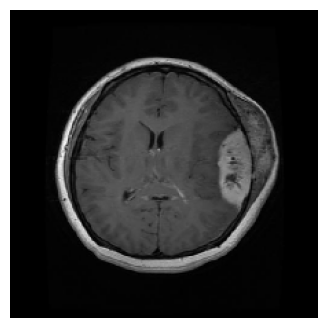

In [5]:
# Beispiel: Datenvorverarbeitung

# Bild laden und auf Größe 224x224 skalieren
im = load_img(train_paths[500], target_size=(224, 224))

# Bild in ein Array umwandeln
im = img_to_array(im)

# Dem Array eine Batch-Dimension hinzufügen
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}\n')

# Array normalisieren -> Pixelwerte zw. 0 und 1
im /= np.max(im)

# Array zurück in Bildformat umwandeln und anzeigen
im = array_to_img(im[0])
plt.figure(figsize=(4, 4))  # Größe anpassen (Breite, Höhe)
plt.imshow(im)  # Im ist ein Bildarray
plt.axis('off')  
plt.show()  

In [6]:
# Bildgröße
image_size = (224, 224)
# Konsistenz zwischen selbsterstelltes CNN-Modell und Resnet50

# Batchgröße
batch_size = 32

In [7]:
# Datenvorverarbeitung

# ImageDataGenerator für die Trainingsdaten 
train_datagen = ImageDataGenerator(rescale=1/255,
                                  )


# Generator für Training mit Seed und Split
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# ImageDataGenerator für die Testingdaten 
test_datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.7  # 70% der Daten für Testing
                                 )

# Generator für Valdierung mit Seed
val_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=False, 
                                                subset='training',  # Setzt die 30% der Daten für die Validierung
                                                seed=SEED)


# Generator für Testing mit Seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  subset='validation',  # Setzt die 70% der Daten für das Testing
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 917 images belonging to 4 classes.


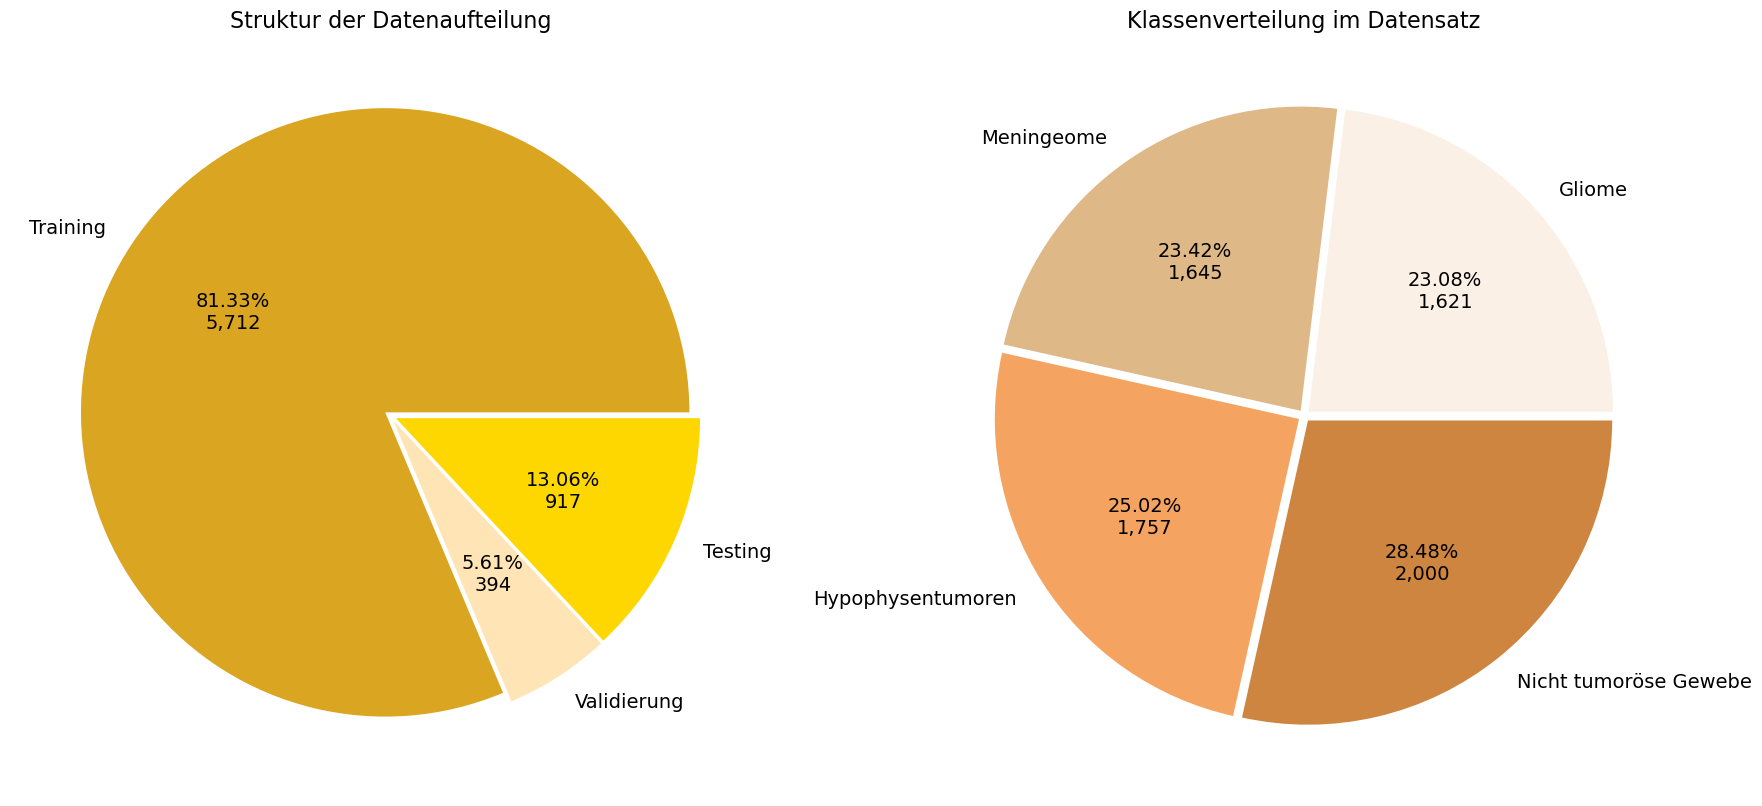

In [8]:
# Gesamtdaten und ihre Verteilung
total_data = 7023
train_data = 5712  # Trainings- und Validierungsdaten
test_data = 1311  # Testdaten
test_split = 917  # 70% für Training
val_split = test_data - test_split  # 30% für Validierung

# Verteilung nach Klassen (absolute Werte)
glioma_count = 1621
meningioma_count = 1645
pituitary_count = 1757
no_tumor_count = 2000

class_counts = [glioma_count, meningioma_count, pituitary_count, no_tumor_count]
class_names = ['Gliome', 'Meningeome', 'Hypophysentumoren', 'Nicht tumoröse Gewebe']

# Prozentuale Verteilung der Klassen
class_percentages = [(count / total_data) * 100 for count in class_counts]

# Farben für die Diagramme
colors_split = ['goldenrod', 'moccasin', 'gold']
colors_classes = ['linen', 'burlywood', 'sandybrown', 'peru']

# Erstellen der Subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# 1. Kreisdiagramm: Split des Datensatzes
ax[0].set_title('Struktur der Datenaufteilung', fontsize=16)
ax[0].pie(
    [train_data, val_split, test_split],
    labels=['Training', 'Validierung', 'Testing'],
    colors=colors_split,
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * total_data / 100),
    explode=(0.02, 0.02, 0.02),
    textprops={'fontsize': 14}
)

# 2. Kreisdiagramm: Klassenverteilung
ax[1].set_title('Klassenverteilung im Datensatz', fontsize=16)
ax[1].pie(
    class_counts,
    labels=class_names,
    colors=colors_classes,
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * total_data / 100),
    explode=(0.02, 0.02, 0.02, 0.02),
    textprops={'fontsize': 14}
)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

In [9]:
# Bilder pro Klasse im train_generator nach dem Split
class_counts_after_split = Counter(train_generator.classes)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Konvertieren in ein Dictionary
class_weights_dict = dict(enumerate(class_weights))

# Klassennamen aus dem train_generator
class_labels = list(train_generator.class_indices.keys())

# Klassennamen den gezählten Werten zuordnen
new_class_counts = np.array([class_counts_after_split[i] for i in range(len(class_labels))])

# Ausgabe der Anzahl der Bilder pro Klasse sowie die Klassengewichte nach dem Split
print("Anzahl der Bilder pro Klasse nach dem Split:", dict(zip(class_labels, new_class_counts)))
print("Klassengewichte:", class_weights_dict)

Anzahl der Bilder pro Klasse nach dem Split: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Klassengewichte: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


In [10]:
# Zugriff auf Klassenindizes für Trainingsdatengenerator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

# Zugriff auf Klassenindizes für Validierungsdatengenerator
class_indices_val = val_generator.class_indices
class_indices_val_list = list(val_generator.class_indices.keys())


# Kategoriale Typen
print("Kategoriale Typen für die Trainingsdaten:")
print(class_indices_train)
print("\nKategoriale Typen für die Validierungsdaten:")
print(class_indices_val)

Kategoriale Typen für die Trainingsdaten:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Kategoriale Typen für die Validierungsdaten:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [11]:
# Bildform: Höhe, Breite, RBG
image_shape = (image_size[0], image_size[1], 3)

# Trainingsepochen
epochs = 100

# Schritte pro Epoche
steps_per_epoch = train_generator.samples // batch_size

# Validierungsschritte
validation_steps = val_generator.samples // batch_size; 

print(f'Bildform: {image_shape}')
print(f'Epochen: {epochs}')
print(f'Batchgröße: {batch_size}')
print(f'Schritte pro Epoche: {steps_per_epoch}')
print(f'Validierungsschritte: {validation_steps}')

Bildform: (224, 224, 3)
Epochen: 100
Batchgröße: 32
Schritte pro Epoche: 178
Validierungsschritte: 12


# Selbst entwickeltes CNN

In [12]:
# Modellarchitektur

model = models.Sequential([
    
    # 1. Konvolutionaler Block
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape, name='Conv2D_32'),
    BatchNormalization(name='BatchNorm_1'),  
    MaxPooling2D(pool_size=(3, 3), name='MaxPooling2D_1'),

    # 2. Konvolutionaler Block
    Conv2D(64, (4, 4), activation="relu", name='Conv2D_64'),
    BatchNormalization(name='BatchNorm_2'),  
    MaxPooling2D(pool_size=(3, 3), name='MaxPooling2D_2'),

    # 3. Konvolutionaler Block
    Conv2D(128, (4, 4), activation="relu", name='Conv2D_128'),
    BatchNormalization(name='BatchNorm_3'),  
    MaxPooling2D(pool_size=(3, 3), name='MaxPooling2D_3'),

    # 4. Konvolutionaler Block
    Conv2D(256, (4, 4), activation="relu", name='Conv2D_256'),
    BatchNormalization(name='BatchNorm_4'),  
    
    # Vollständig verbundene Layer
    Flatten(name='Flatten_Layer'),
    Dense(1024, activation="relu", kernel_regularizer=l2(0.001), name='Dense_1024'),
    Dropout(0.5, seed=SEED, name='Dropout_1'),
    Dense(N_TYPES, activation="softmax", kernel_regularizer=l2(0.001), name='Output_Layer')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_32 (Conv2D)          (None, 221, 221, 32)      1568      
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 221, 221, 32)     128       
 tion)                                                           
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 73, 73, 32)       0         
 D)                                                              
                                                                 
 Conv2D_64 (Conv2D)          (None, 70, 70, 64)        32832     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 70, 70, 64)       256       
 tion)                                                           
                                                        

In [13]:
# Modell kompilieren
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

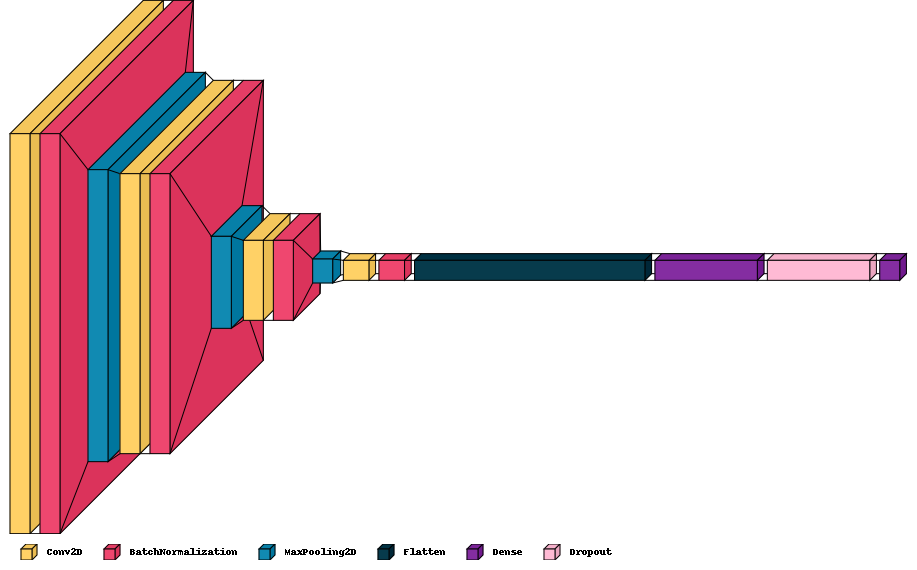

In [14]:
# Modellarchitektur visualisieren
visualkeras.layered_view(model, legend=True, max_xy = 400)

In [15]:
# Callback für das Modell 
model_es = EarlyStopping(monitor='val_loss', patience=10, verbose=True, restore_best_weights=True)

In [16]:
# Modelltraining
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=class_weights_dict,
                    callbacks=[model_es])

Epoch 1/100
178/178 [==============================] - 53s 281ms/step - loss: 2.0242 - accuracy: 0.7764 - val_loss: 2.5917 - val_accuracy: 0.4974
Epoch 2/100
178/178 [==============================] - 24s 132ms/step - loss: 1.6297 - accuracy: 0.9079 - val_loss: 2.4719 - val_accuracy: 0.5885
Epoch 3/100
178/178 [==============================] - 23s 129ms/step - loss: 1.4841 - accuracy: 0.9424 - val_loss: 2.5288 - val_accuracy: 0.6510
Epoch 4/100
178/178 [==============================] - 23s 128ms/step - loss: 1.3803 - accuracy: 0.9657 - val_loss: 1.5821 - val_accuracy: 0.8672
Epoch 5/100
178/178 [==============================] - 25s 142ms/step - loss: 1.2859 - accuracy: 0.9798 - val_loss: 1.5444 - val_accuracy: 0.8802
Epoch 6/100
178/178 [==============================] - 26s 147ms/step - loss: 1.2179 - accuracy: 0.9850 - val_loss: 1.4119 - val_accuracy: 0.8880
Epoch 7/100
178/178 [==============================] - 26s 143ms/step - loss: 1.1420 - accuracy: 0.9917 - val_loss: 1.3882 -

Epoch 57/100
178/178 [==============================] - 29s 158ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.2158 - val_accuracy: 0.9479
Epoch 58/100
178/178 [==============================] - 27s 152ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.2049 - val_accuracy: 0.9479
Epoch 59/100
178/178 [==============================] - 28s 155ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.1782 - val_accuracy: 0.9505
Epoch 59: early stopping


In [17]:
# Evaluierung des Modells
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

28/28 [==============================] - 3s 94ms/step - loss: 0.1027 - accuracy: 0.9810
Test Loss: 0.10270
Test Accuracy: 0.98103


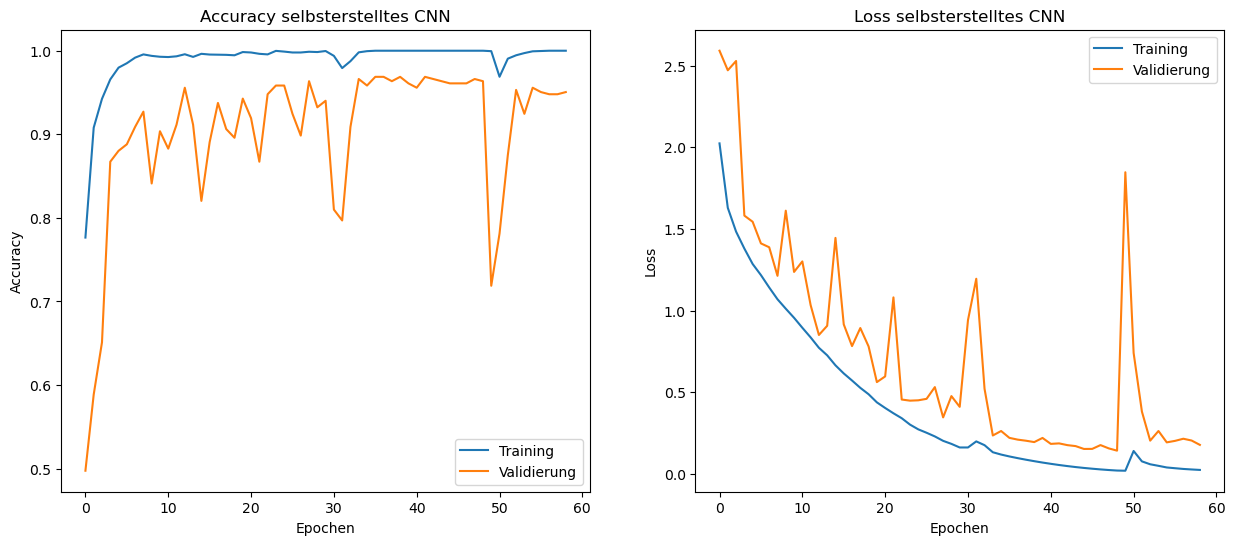

In [18]:
# Lernkurven: Accuracy und Loss

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot der Trainings- und Validierungsgenauigkeit über Epochen
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy selbsterstelltes CNN')
ax[0].set_xlabel('Epochen')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training', 'Validierung'])

# Plot der Trainings- und Validierungsverlust über Epochen
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss selbsterstelltes CNN')
ax[1].set_xlabel('Epochen')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training', 'Validierung'])

plt.show()

In [19]:
# Vorhersagen für die Testdaten
predictions = model.predict(test_generator)

# Die Vorhersagen in Klassen umwandeln
predicted_classes = np.argmax(predictions, axis=1)

# Die tatsächlichen Klassen
true_classes = test_generator.classes

# Klassenbezeichnungen
class_labels = list(test_generator.class_indices.keys())

29/29 [==============================] - 4s 120ms/step


<Figure size 1000x800 with 0 Axes>

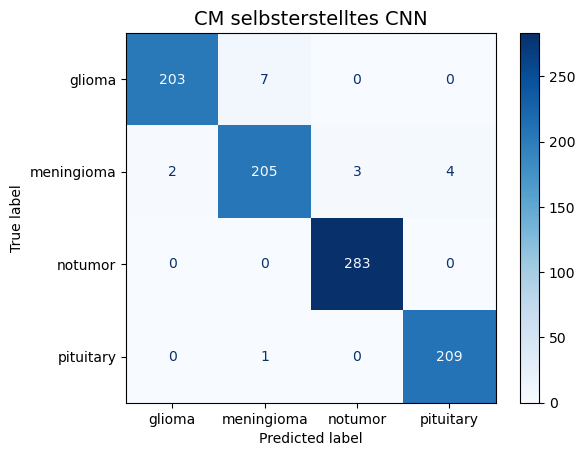

In [20]:
# Kunfusionmatrix erstellen
cm = confusion_matrix(true_classes, predicted_classes)

# Erstelle eine Abbildung
plt.figure(figsize=(10, 8))

# Plot der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('CM selbsterstelltes CNN', fontsize=14)
plt.show()

In [21]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       210
  meningioma       0.96      0.96      0.96       214
     notumor       0.99      1.00      0.99       283
   pituitary       0.98      1.00      0.99       210

    accuracy                           0.98       917
   macro avg       0.98      0.98      0.98       917
weighted avg       0.98      0.98      0.98       917



# ResNet50 mit FT (Output)

In [22]:
# Basis des vortrainierten ResNet50-Modells laden
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3)
)

In [23]:
# Schichten einfrieren
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Output Layer oben hinzufügen
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)
output_layer = Dense(N_TYPES, activation='softmax')(x)

In [25]:
# Modell definieren
model_resnet = Model(inputs=base_model.input, outputs=output_layer)

In [26]:
# Modell kompilieren
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# Modell trainieren (nur Output)
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size, 
    class_weight=class_weights_dict,
    callbacks=[model_es]
)

Epoch 1/100
178/178 [==============================] - 34s 177ms/step - loss: 1.3030 - accuracy: 0.3954 - val_loss: 1.1484 - val_accuracy: 0.3854
Epoch 2/100
178/178 [==============================] - 30s 167ms/step - loss: 1.0840 - accuracy: 0.5386 - val_loss: 1.0241 - val_accuracy: 0.5260
Epoch 3/100
178/178 [==============================] - 30s 167ms/step - loss: 0.9898 - accuracy: 0.6030 - val_loss: 0.9329 - val_accuracy: 0.6484
Epoch 4/100
178/178 [==============================] - 29s 166ms/step - loss: 0.9289 - accuracy: 0.6421 - val_loss: 0.9298 - val_accuracy: 0.6198
Epoch 5/100
178/178 [==============================] - 29s 165ms/step - loss: 0.8885 - accuracy: 0.6555 - val_loss: 0.8611 - val_accuracy: 0.6380
Epoch 6/100
178/178 [==============================] - 29s 165ms/step - loss: 0.8582 - accuracy: 0.6741 - val_loss: 0.8266 - val_accuracy: 0.6875
Epoch 7/100
178/178 [==============================] - 29s 163ms/step - loss: 0.8247 - accuracy: 0.6868 - val_loss: 0.7976 -

Epoch 57/100
178/178 [==============================] - 32s 181ms/step - loss: 0.5157 - accuracy: 0.8009 - val_loss: 0.5332 - val_accuracy: 0.7474
Epoch 58/100
178/178 [==============================] - 33s 183ms/step - loss: 0.5140 - accuracy: 0.8012 - val_loss: 0.5604 - val_accuracy: 0.7188
Epoch 59/100
178/178 [==============================] - 42s 237ms/step - loss: 0.5102 - accuracy: 0.7928 - val_loss: 0.5263 - val_accuracy: 0.7422
Epoch 60/100
178/178 [==============================] - 30s 169ms/step - loss: 0.5114 - accuracy: 0.8044 - val_loss: 0.5192 - val_accuracy: 0.7344
Epoch 61/100
178/178 [==============================] - 31s 173ms/step - loss: 0.5053 - accuracy: 0.8009 - val_loss: 0.4930 - val_accuracy: 0.7682
Epoch 62/100
178/178 [==============================] - 32s 177ms/step - loss: 0.5008 - accuracy: 0.8018 - val_loss: 0.5198 - val_accuracy: 0.7448
Epoch 63/100
178/178 [==============================] - 33s 184ms/step - loss: 0.5071 - accuracy: 0.8035 - val_loss: 0

In [28]:
# Evaluierung des Modells
loss, accuracy = model_resnet.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

28/28 [==============================] - 4s 144ms/step - loss: 0.5825 - accuracy: 0.7645
Test Loss: 0.58246
Test Accuracy: 0.76451


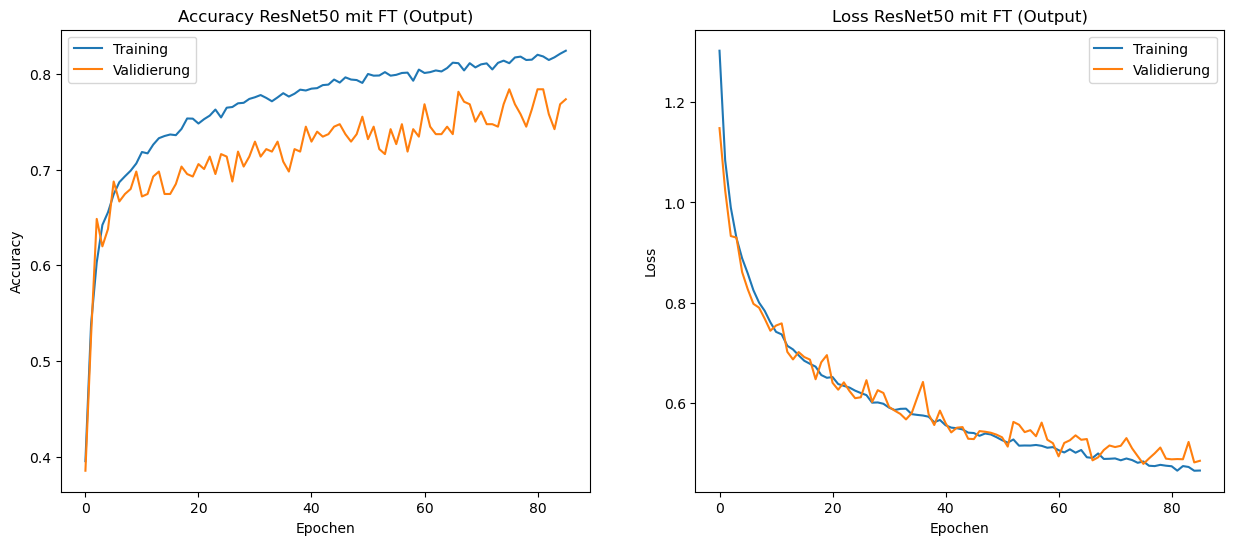

In [29]:
# Lernkurven: Accuracy und Loss

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot der Trainings- und Validierungsgenauigkeit über Epochen
ax[0].plot(history_resnet.history['accuracy'])
ax[0].plot(history_resnet.history['val_accuracy'])
ax[0].set_title('Accuracy ResNet50 mit FT (Output)')
ax[0].set_xlabel('Epochen')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training', 'Validierung'])

# Plot der Trainings- und Validierungsverlust über Epochen
ax[1].plot(history_resnet.history['loss'])
ax[1].plot(history_resnet.history['val_loss'])
ax[1].set_title('Loss ResNet50 mit FT (Output)')
ax[1].set_xlabel('Epochen')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training', 'Validierung'])

plt.show()

In [30]:
# Vorhersagen für die Testdaten
predictions_resnet = model_resnet.predict(test_generator)

# Die Vorhersagen in Klassen umwandeln
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)

# Die tatsächlichen Klassen
true_classes_resnet = test_generator.classes

# Klassenbezeichnungen
class_labels_resnet = list(test_generator.class_indices.keys())

29/29 [==============================] - 5s 167ms/step


<Figure size 1000x800 with 0 Axes>

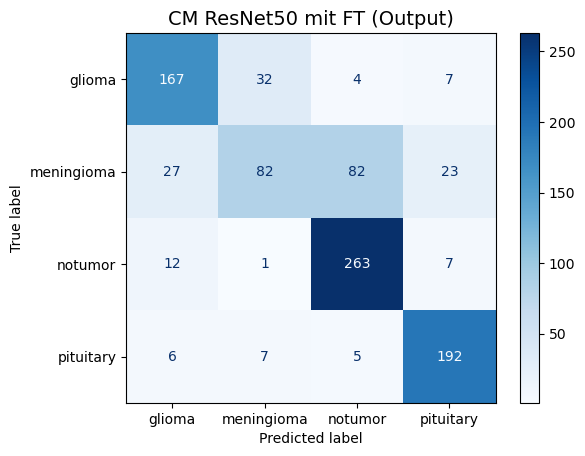

In [31]:
# Kunfusionmatrix erstellen
cm_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)

# Erstelle eine Abbildung
plt.figure(figsize=(10, 8))

# Plot der Konfusionsmatrix
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet,
                              display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp_resnet.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('CM ResNet50 mit FT (Output)', fontsize=14)
plt.show()

In [32]:
report_resnet = classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels)
print(report_resnet)

              precision    recall  f1-score   support

      glioma       0.79      0.80      0.79       210
  meningioma       0.67      0.38      0.49       214
     notumor       0.74      0.93      0.83       283
   pituitary       0.84      0.91      0.87       210

    accuracy                           0.77       917
   macro avg       0.76      0.76      0.75       917
weighted avg       0.76      0.77      0.75       917



# ResNet50 mit FT (20 Schichten)

In [33]:
# Anzahl der zu trainierenden Schichten bestimmen
trainable_layers = 20  # Passe diesen Wert an: 10–20 für kleine Datensätze, bis zu 50 für größere

# Letzte n Schichten freigeben
for layer in base_model.layers[-trainable_layers:]:
    layer.trainable = True

In [34]:
# Modell definieren
model_resnet_ft = Model(inputs=base_model.input, outputs=output_layer)

In [35]:
# Modell neu kompilieren mit einer niedrigeren Lernrate
model_resnet_ft.compile(
    optimizer=Adam(learning_rate= 1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# FT-Modell trainieren 
history_resnet_ft = model_resnet_ft.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,  
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size, 
    class_weight=class_weights_dict,
    callbacks=[model_es]
)

Epoch 1/100
178/178 [==============================] - 38s 198ms/step - loss: 2.3546 - accuracy: 0.7116 - val_loss: 6.5852 - val_accuracy: 0.4427
Epoch 2/100
178/178 [==============================] - 34s 192ms/step - loss: 0.4870 - accuracy: 0.8370 - val_loss: 1.6494 - val_accuracy: 0.5078
Epoch 3/100
178/178 [==============================] - 32s 178ms/step - loss: 0.3545 - accuracy: 0.8708 - val_loss: 0.3792 - val_accuracy: 0.8411
Epoch 4/100
178/178 [==============================] - 32s 180ms/step - loss: 0.2526 - accuracy: 0.9056 - val_loss: 0.3042 - val_accuracy: 0.8620
Epoch 5/100
178/178 [==============================] - 33s 180ms/step - loss: 0.1929 - accuracy: 0.9264 - val_loss: 0.2734 - val_accuracy: 0.8854
Epoch 6/100
178/178 [==============================] - 34s 193ms/step - loss: 0.1547 - accuracy: 0.9417 - val_loss: 0.2723 - val_accuracy: 0.8828
Epoch 7/100
178/178 [==============================] - 34s 193ms/step - loss: 0.1440 - accuracy: 0.9523 - val_loss: 0.4544 -

In [37]:
# Evaluierung des Modells
loss, accuracy = model_resnet_ft.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

28/28 [==============================] - 5s 172ms/step - loss: 0.1051 - accuracy: 0.9743
Test Loss: 0.10510
Test Accuracy: 0.97433


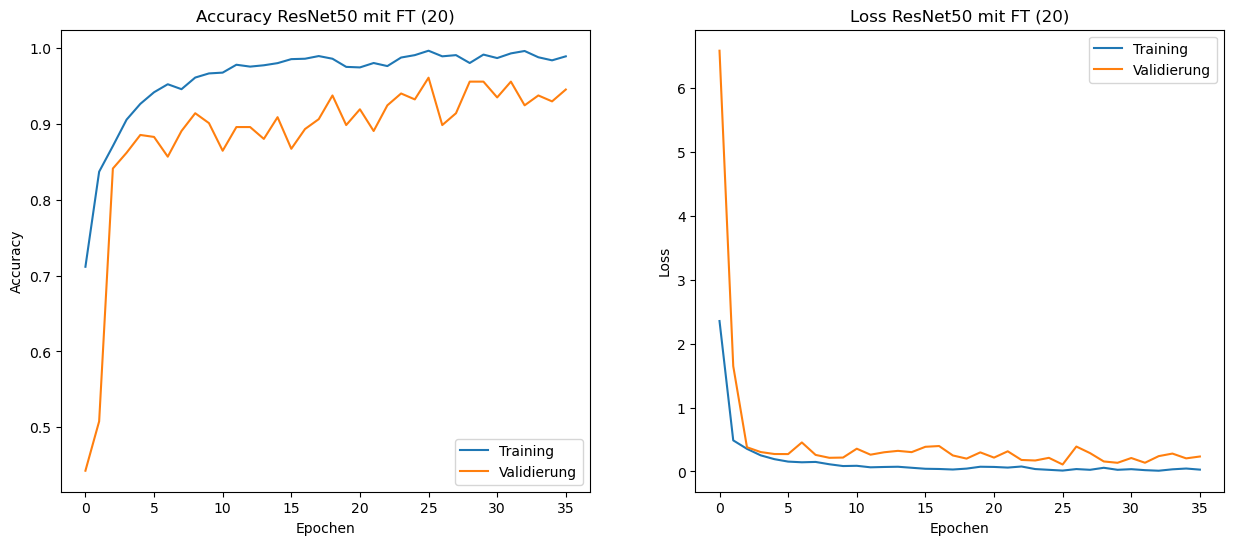

In [38]:
# Lernkurven: Accuracy und Loss

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot der Trainings- und Validierungsgenauigkeit über Epochen
ax[0].plot(history_resnet_ft.history['accuracy'])
ax[0].plot(history_resnet_ft.history['val_accuracy'])
ax[0].set_title('Accuracy ResNet50 mit FT (20)')
ax[0].set_xlabel('Epochen')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training', 'Validierung'])

# Plot der Trainings- und Validierungsverlust über Epochen
ax[1].plot(history_resnet_ft.history['loss'])
ax[1].plot(history_resnet_ft.history['val_loss'])
ax[1].set_title('Loss ResNet50 mit FT (20)')
ax[1].set_xlabel('Epochen')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training', 'Validierung'])

plt.show()

In [39]:
# Vorhersagen für die Testdaten
predictions_resnet_ft = model_resnet_ft.predict(test_generator)

# Die Vorhersagen in Klassen umwandeln
predicted_classes_resnet_ft = np.argmax(predictions_resnet_ft, axis=1)

# Die tatsächlichen Klassen
true_classes_resnet_ft = test_generator.classes

# Klassenbezeichnungen
class_labels_resnet_ft = list(test_generator.class_indices.keys())

29/29 [==============================] - 5s 158ms/step


<Figure size 1000x800 with 0 Axes>

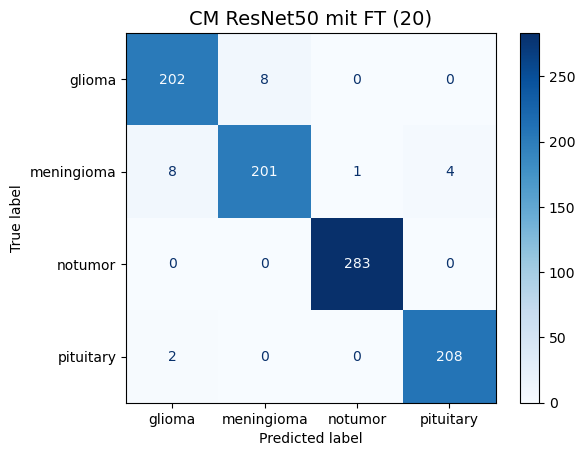

In [40]:
# Konfusionmatrix erstellen
cm_resnet_ft = confusion_matrix(true_classes_resnet_ft, predicted_classes_resnet_ft)

# Erstelle eine Abbildung
plt.figure(figsize=(10, 8))

# Plot der Konfusionsmatrix
disp_resnet_ft = ConfusionMatrixDisplay(confusion_matrix=cm_resnet_ft,
                              display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp_resnet_ft.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('CM ResNet50 mit FT (20)', fontsize=14)
plt.show()

In [41]:
report_resnet_ft = classification_report(true_classes_resnet_ft, predicted_classes_resnet_ft, target_names=class_labels)
print(report_resnet_ft)

              precision    recall  f1-score   support

      glioma       0.95      0.96      0.96       210
  meningioma       0.96      0.94      0.95       214
     notumor       1.00      1.00      1.00       283
   pituitary       0.98      0.99      0.99       210

    accuracy                           0.97       917
   macro avg       0.97      0.97      0.97       917
weighted avg       0.97      0.97      0.97       917



# Resnet50 mit FT - HPO

In [42]:
def build_resnet_model(hp):
    # Hyperparameter für die Anzahl der trainierbaren Schichten
    trainable_layers_range = hp.Int('trainable_layers', min_value=1, max_value=25, step=1)

    # ResNet50-Modell laden (ohne Top Layer)
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(image_size[0], image_size[1], 3)
    )

    # Alle Schichten einfrieren
    for layer in base_model.layers:
        layer.trainable = False

    # Letzte 'trainable_layers' Schichten freigeben
    for layer in base_model.layers[-trainable_layers_range:]:
        layer.trainable = True

    # Output hinzufügen
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(N_TYPES, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Modell definieren
    model_resnet_grid = Model(inputs=base_model.input, outputs=output_layer)

    # Modell kompilieren
    model_resnet_grid.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model_resnet_grid


# Tuner für Grid Search konfigurieren
tuner_resnet_grid = kt.GridSearch(
    build_resnet_model,
    objective='val_loss',
    max_trials=25,  # Anzahl der Versuche (entspricht Anzahl der möglichen Kombinationen im Raster)
    executions_per_trial=3,  # Mehrere Durchläufe für jede Kombination
    directory='C:/Julian/UNI/BA_Tumor_Classification/HPO', 
    project_name='C:/Julian/UNI/BA_Tumor_Classification/HPO/HPO_ResNet'
)

# Tuner ausführen
tuner_resnet_grid.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

# Beste Modelle abrufen
best_model_resnet_grid = tuner_resnet_grid.get_best_models(num_models=1)[0]
print("Beste Hyperparameter: ", tuner_resnet_grid.get_best_hyperparameters(num_trials=1)[0].values)

Trial 25 Complete [00h 23m 44s]
val_loss: 0.15365925431251526

Best val_loss So Far: 0.1375112533569336
Total elapsed time: 11h 37m 54s
Beste Hyperparameter:  {'trainable_layers': 23}


In [44]:
results = []
trials = tuner_resnet_grid.oracle.get_best_trials(num_trials=25)

for trial in trials:
    hyperparameters = trial.hyperparameters.values
    train_accuracy = trial.metrics.get_last_value('accuracy')  # Train Accuracy
    val_accuracy = trial.metrics.get_last_value('val_accuracy')  # Validierung Accuracy
    train_loss = trial.metrics.get_last_value('loss')  # Train Loss
    val_loss = trial.metrics.get_last_value('val_loss')  # Validierung Loss
    
    results.append({
        'trainable_layers': hyperparameters['trainable_layers'],
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

In [45]:
results_df = pd.DataFrame(results)

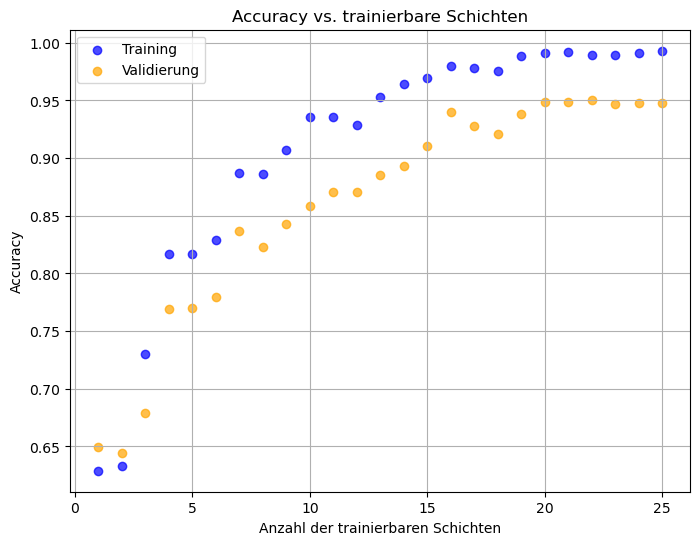

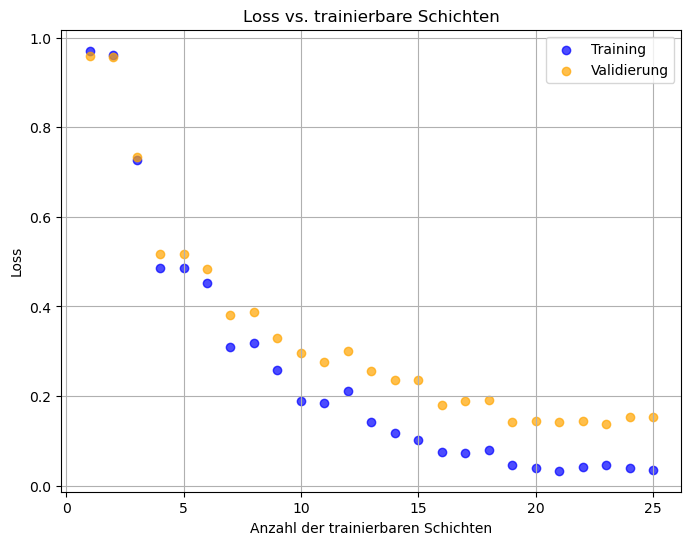

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df['trainable_layers'], results_df['train_accuracy'], marker='o', label='Training', color='blue', alpha=0.7)
plt.scatter(results_df['trainable_layers'], results_df['val_accuracy'], marker='o', label='Validierung', color='orange', alpha=0.7)
plt.xlabel('Anzahl der trainierbaren Schichten')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. trainierbare Schichten')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(results_df['trainable_layers'], results_df['train_loss'], marker='o', label='Training', color='blue', alpha=0.7)
plt.scatter(results_df['trainable_layers'], results_df['val_loss'], marker='o', label='Validierung', color='orange', alpha=0.7)
plt.xlabel('Anzahl der trainierbaren Schichten')
plt.ylabel('Loss')
plt.title('Loss vs. trainierbare Schichten')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Training des Modells mit Callbacks
history_resnet_grid = best_model_resnet_grid.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[model_es]
)

Epoch 1/100
178/178 [==============================] - 27s 141ms/step - loss: 0.0435 - accuracy: 0.9891 - val_loss: 0.3122 - val_accuracy: 0.9193
Epoch 2/100
178/178 [==============================] - 24s 132ms/step - loss: 0.0461 - accuracy: 0.9887 - val_loss: 0.2670 - val_accuracy: 0.9297
Epoch 3/100
178/178 [==============================] - 24s 132ms/step - loss: 0.0334 - accuracy: 0.9935 - val_loss: 0.3288 - val_accuracy: 0.9062
Epoch 4/100
178/178 [==============================] - 23s 132ms/step - loss: 0.0333 - accuracy: 0.9921 - val_loss: 0.1808 - val_accuracy: 0.9401
Epoch 5/100
178/178 [==============================] - 23s 131ms/step - loss: 0.0392 - accuracy: 0.9907 - val_loss: 0.1983 - val_accuracy: 0.9297
Epoch 6/100
178/178 [==============================] - 23s 131ms/step - loss: 0.0253 - accuracy: 0.9956 - val_loss: 0.2069 - val_accuracy: 0.9323
Epoch 7/100
178/178 [==============================] - 23s 131ms/step - loss: 0.0239 - accuracy: 0.9944 - val_loss: 0.3849 -

In [48]:
# Evaluierung des Modells
loss, accuracy = best_model_resnet_grid.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

28/28 [==============================] - 3s 115ms/step - loss: 0.1097 - accuracy: 0.9766
Test Loss: 0.10972
Test Accuracy: 0.97656


In [50]:
# Vorhersagen für die Testdaten
predictions_resnet_grid = best_model_resnet_grid.predict(test_generator)

# Die Vorhersagen in Klassen umwandeln
predicted_classes_resnet_grid = np.argmax(predictions_resnet_grid, axis=1)

# Die tatsächlichen Klassen
true_classes_resnet_grid = test_generator.classes

# Klassenbezeichnungen
class_labels_resnet_grid = list(test_generator.class_indices.keys())

29/29 [==============================] - 3s 108ms/step


<Figure size 1000x800 with 0 Axes>

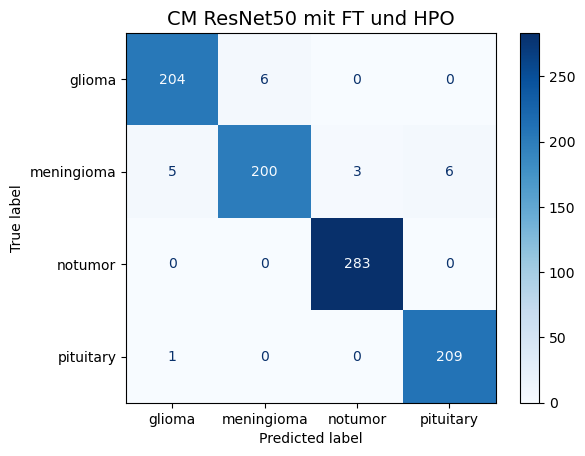

In [51]:
# Konfusionmatrix erstellen
cm_resnet_grid = confusion_matrix(true_classes_resnet_grid, predicted_classes_resnet_grid)

# Erstelle eine Abbildung
plt.figure(figsize=(10, 8))

# Plot der Konfusionsmatrix
disp_resnet_grid = ConfusionMatrixDisplay(confusion_matrix=cm_resnet_grid,
                              display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp_resnet_grid.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('CM ResNet50 mit FT und HPO', fontsize=14)
plt.show()

In [52]:
report_resnet_grid = classification_report(true_classes_resnet_grid, predicted_classes_resnet_grid, target_names=class_labels)
print(report_resnet_grid)

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       210
  meningioma       0.97      0.93      0.95       214
     notumor       0.99      1.00      0.99       283
   pituitary       0.97      1.00      0.98       210

    accuracy                           0.98       917
   macro avg       0.98      0.98      0.98       917
weighted avg       0.98      0.98      0.98       917

